In [8]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [9]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [10]:
train_file = "datasets/train.csv.zip"
test_file = "datasets/test.csv.zip"
output_file = "datasets/submission.csv"


In [13]:
raw_data = pd.read_csv(train_file, compression="zip", header=0)
x_train, x_val, y_train, y_val = train_test_split(
    raw_data.iloc[:,1:], raw_data.iloc[:,0], test_size=0.1)

Text(0.5, 1.0, '28x28 data')

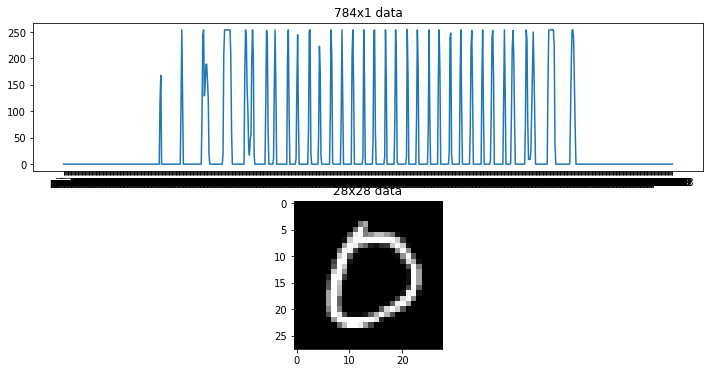

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
first_row = x_train.iloc[0]
ax[0].plot(first_row)
ax[0].set_title("784x1 data")
ax[1].imshow(first_row.values.reshape(28, 28), cmap="gray")
ax[1].set_title("28x28 data")


In [18]:
x_train = x_train.values.reshape(-1, 28, 28, 1)
x_val = x_val.values.reshape(-1, 28, 28, 1)

In [19]:
x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0


In [20]:
y_train = to_categorical(y_train.values)
y_val = to_categorical(y_val.values)
# example:
print(y_train[0])


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
model = Sequential()

model.add(
    Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1))
)
model.add(BatchNormalization())
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu"))
model.add(BatchNormalization())
# model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
model.add(BatchNormalization())
# model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))


In [22]:
datagen = ImageDataGenerator(
    zoom_range=0.1, height_shift_range=0.1, width_shift_range=0.1, rotation_range=10
)


In [31]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    # optimizer="adam",
    metrics=["accuracy"],
)


In [32]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9**x)


In [33]:
hist = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=16),
    steps_per_epoch=500,
    epochs=20,  # Increase this when not on Kaggle kernel
    verbose=2,  # 1 for ETA, 0 for silent
    validation_data=(x_val[:400, :], y_val[:400, :]),  # For speed
    callbacks=[annealer],
)


C:\Users\urosm\AppData\Local\Temp/ipykernel_71724/3747331476.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/20
500/500 - 10s - loss: 0.7941 - accuracy: 0.7499 - val_loss: 0.1858 - val_accuracy: 0.9400 - lr: 0.0010 - 10s/epoch - 20ms/step
Epoch 2/20
500/500 - 9s - loss: 0.3379 - accuracy: 0.9003 - val_loss: 0.0872 - val_accuracy: 0.9700 - lr: 9.0000e-04 - 9s/epoch - 18ms/step
Epoch 3/20
500/500 - 8s - loss: 0.2383 - accuracy: 0.9289 - val_loss: 0.0526 - val_accuracy: 0.9875 - lr: 8.1000e-04 - 8s/epoch - 16ms/step
Epoch 4/20
500/500 - 8s - loss: 0.2006 - accuracy: 0.9394 - val_loss: 0.0562 - val_accuracy: 0.9850 - lr: 7.2900e-04 - 8s/epoch - 16ms/step
Epoch 5/20
500/500 - 8s - loss: 0.1834 - accuracy: 0.9449 - val_loss: 0.0460 - val_accuracy: 0.9900 - lr: 6.5610e-04 - 8s/epoch - 17ms/step
Epoch 6/20
500/500 - 9s - loss: 0.1546 - accuracy: 0.9540 - val_loss: 0.0514 - val_accuracy: 0.9875 - lr: 5.9049e-04 - 9s/epoch - 18ms/step
Epoch 7/20
500/500 - 9s - loss: 0.1506 - accuracy: 0.9563 - val_loss: 0.0407 - val_accuracy: 0.9925 - lr: 5.3144e-04 - 9s/epoch - 18ms/step
Epoch 8/20
500/500 - 8

In [34]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))


Final loss: 0.0293, final accuracy: 0.9905


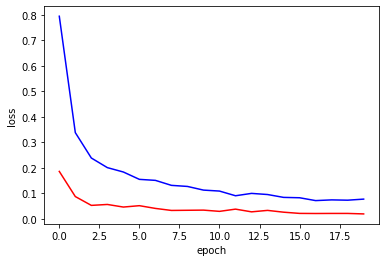

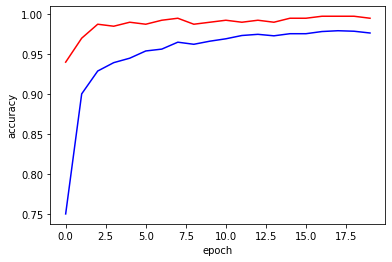

In [37]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()
plt.plot(hist.history['accuracy'], color='b')
plt.plot(hist.history['val_accuracy'], color='r')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [38]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[401   0   0   0   0   2   0   0   0   0]
 [  0 461   0   0   0   0   0   2   0   0]
 [  0   1 438   0   1   0   0   3   1   0]
 [  1   0   2 428   0   3   0   0   0   0]
 [  0   1   0   0 380   0   1   0   0   3]
 [  0   0   0   0   0 397   3   0   2   0]
 [  1   0   2   0   0   0 397   0   0   0]
 [  0   1   1   0   1   0   0 407   0   0]
 [  0   0   1   0   0   1   0   0 410   0]
 [  0   0   1   0   2   1   0   1   1 441]]
